# GradCAM - Gradient Class Activation Map

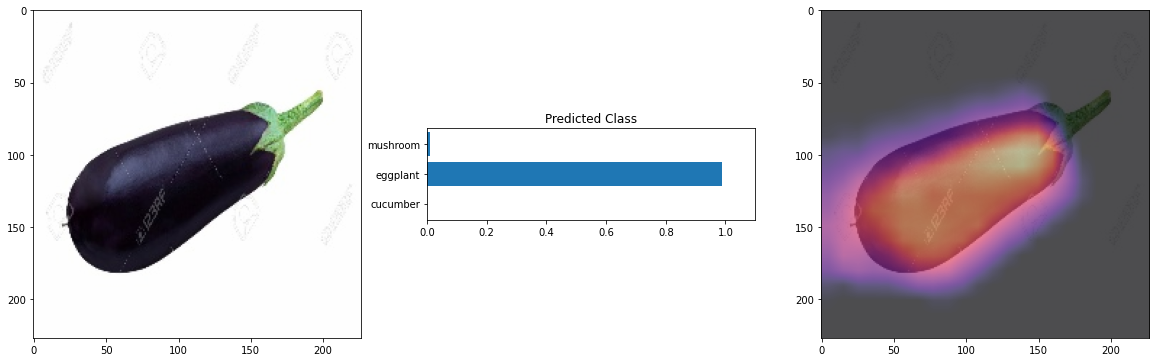

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 27.60 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pxk3lpqq
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pxk3lpqq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset'

DEVICE = 'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [ ]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.546,0.406], std = [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.546,0.406], std = [0.229, 0.224, 0.225])
])

# Load Image Dataset 

In [ ]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)


In [ ]:
image, label = trainset[1]

plt.imshow(image.permut(1,2,0))
plt.title(label);

error: ignored

In [ ]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

error: ignored

# Create Model 

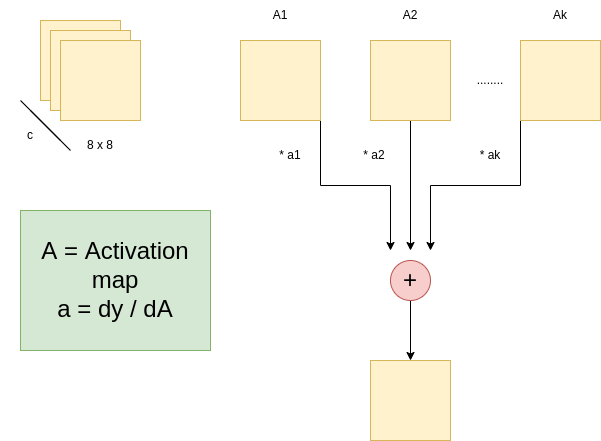

In [ ]:
from torch.nn.modules.pooling import MaxPool2d

class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size=(5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),

        nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=(5,5), padding = 1),
        nn.ReLU()
    )

    self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048,3)
    )

    self.gradient = None


  def activations_hook(self, grad):
    self.gradient = grad 


  def forward(self, images):

    x= self.feature_extractor(images)

    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)

    return x


  def get_activation_gradient(self):
    return self.gradient

  def get_activation(self, x):
    return self.feature_extractor(x)

In [ ]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [ ]:
def train_fn(dataloader, model, optimizer, criterion):

  model.train()
  total_loss = 0.0
  for image, labesl in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader, model,criterion):

  model.eval()
  total_loss = 0.0
  for image, labesl in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    logits = model(images)

    loss = criterion(logits, labels)

    total_loss += loss.item()

  return total_loss/len(dataloader)

# Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("SAVE WEIGHTS SUCCESSFUL")

  print("Epoch", i+1, "Train Loss", train_loss, "Valid Loss", valid_loss)

  0%|          | 0/10 [00:00<?, ?it/s]


error: ignored

# Get GradCAM

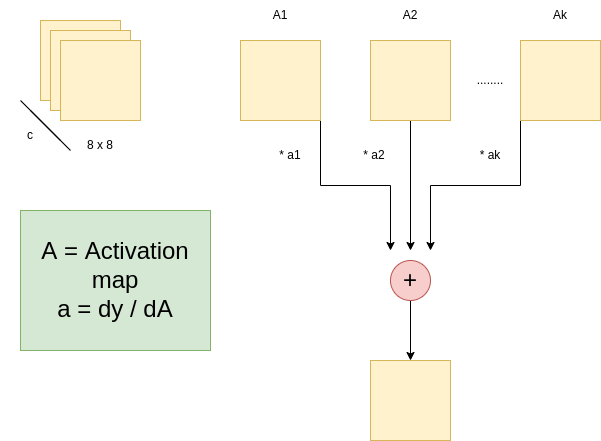

In [ ]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradient()
  pooled_gradients = torch.mean(gradients, dim = [0,2,3])

  activations = model.get_activation(image).detach()

  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

In [ ]:
image, label = validset[4]

denorm_image = image.permute(1,2,0) * np.array((0.229,0.224,0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)

error: ignored